In [ ]:
import numpy as np
import os
import json
import re
import joblib
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import tensorflow as tf
import tensorflow.keras as keras

import smfret.fit as fit

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import TwoStateQuickDynamicTraceSet
from smfret.dataset import MatlabTraceSet
from smfret.dataset import FRETTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics
import sklearn
from sklearn import mixture

import functools
import umap
import scipy

from sciplotlib import style as spstyle
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

In [2]:
rng = np.random.default_rng()

In [3]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')
encoder = keras.models.load_model('../../saved_models/best_model/encoder-20240111-045226.h5', compile=False)

In [4]:
def interpolate_position_embedding(position_embedding, periodicity=40):
    """Interpolates the position embedding vectors."""
    vectors = []
    w = position_embedding.variables[0]
    for i in range(w.shape[0]):
        if i == 0:
            vectors.append(w[i, :])
        elif i < periodicity:
            vectors.append(w[i, :])
        else:
            vectors.append(w[i - periodicity + 1, :])
    position_embedding.variables[0].assign(tf.stack(vectors, axis=0))

In [5]:
position_embedding = encoder.layers[-1].transformer.position_embedding
interpolate_position_embedding(position_embedding, periodicity=40)

In [6]:
NN_K = 50  # how many nearest neighbors are considered for the score

In [7]:
def calculate_distance(embedding):
    """Calculates the distance matrix from the embeddings."""
    distance = (
        tf.expand_dims(tf.einsum('ik,ik->i', embedding, embedding), axis=-1)
        + tf.expand_dims(tf.einsum('ik,ik->i', embedding, embedding), axis=0)
        - 2.0 * tf.einsum('ik,jk->ij', embedding, embedding))
    return distance

In [8]:
def get_perplexity(embedding, label, branching_factor, use_excess_definition=True, normalize=True):
    """Calculates the perplexity of a trace's neighbors.""" 
    distance = calculate_distance(embedding)
    top_k_results = tf.math.top_k(
        -distance, k=branching_factor + 1, sorted=True, name=None
    )
    top_k_idx = top_k_results.indices.numpy()
    n = embedding.shape[0]
    perplexity = []
    for i in range(n):
        this_label = label[i]
        neighbour_label = label[top_k_idx[i, :].flatten()]
        unique_labels = set(neighbour_label)
        shannon_entropy = 0
        for l in unique_labels:
            p = np.mean(neighbour_label == l)
            shannon_entropy -= p * np.log(p)
        perplexity.append(shannon_entropy)
    return np.array(perplexity)

In [12]:
def generate_embedding_and_label(trace_sets, start_frame, encoder, max_frame=2000, max_traces=4000, balance_labels=True):
    """Generates the embeddings and labels."""

    embeddings = []
    labels = []
    colors = []
    color_count = 1
    image_files = []
    traces = []
    
    count = 0
    for trace_set in trace_sets:
        trim_size = len(trace_set.time) // 100 * 100
        trace_set.trim(trim_size)
        trace_set.trim(max_frame, start_frame=start_frame)
        trace_set.broadcast_data_to_traces()
        print(trace_set.size)
        if count + trace_set.size > max_traces:
            break
        else:
            count += trace_set.size
                
        with tf.device('/CPU:0'):
            label = np.max(trace_set.label, axis=-1)
            if balance_labels:
                n_included = np.sum(label == 1)
                n_excluded = np.sum(label == 0)
                if n_included == 0 or n_excluded == 0:
                    continue
                indices = np.arange(len(label))
                ratio = int(n_excluded / n_included)
                # ratio = 0
                if ratio > 1:
                    indices = np.concatenate([indices[label == 1], indices[label ==0][::ratio]])
                    label = label[indices]
                    trace_set = trace_set.get_subset(indices)

            embedding = encoder.predict(trace_set.to_tensor(), batch_size=8)
            embeddings.append(embedding)
            labels.append(label)
            traces.extend(trace_set.traces)
    return embeddings, labels

In [13]:
config_file = '../../experiment_conditions/cond_rna_bubble_all.json'
with open(config_file) as f:
    config = json.load(f)
trace_sets = [MatlabTraceSet('../../' + file) for file in config['expt_setting_set_files'].strip().split('\n')]
embeddings, labels = generate_embedding_and_label(trace_sets, config['start_frame'], encoder, max_frame=2000, max_traces=20000, balance_labels=False)

504
63/63 [==============================] - 4s 53ms/step
520
65/65 [==============================] - 3s 54ms/step
537
68/68 [==============================] - 4s 55ms/step
488
61/61 [==============================] - 3s 53ms/step
550
69/69 [==============================] - 4s 59ms/step
468
59/59 [==============================] - 3s 57ms/step
457
58/58 [==============================] - 3s 56ms/step
435
55/55 [==============================] - 3s 58ms/step
571
72/72 [==============================] - 4s 54ms/step
519
65/65 [==============================] - 4s 54ms/step
544
68/68 [==============================] - 4s 53ms/step
515
65/65 [==============================] - 3s 52ms/step
499
63/63 [==============================] - 3s 53ms/step
543
68/68 [==============================] - 4s 54ms/step
441
56/56 [==============================] - 3s 54ms/step
454
57/57 [==============================] - 3s 54ms/step
464
58/58 [==============================] - 3s 53ms/step
422
53/53 [===

In [14]:
final_embeddings = []
final_labels = []
human_labels = []
for e, t, l in zip(embeddings, trace_sets, labels):
    final_labels.append([t.file.split('/')[-2]] * e.shape[0])
    final_embeddings.append(e)
    human_labels.append(l)
embedding = np.concatenate(final_embeddings, axis=0)
label = np.concatenate(final_labels)
human_label = np.concatenate(human_labels)

In [17]:
ordered_label_spot = sorted(list(set(label.tolist())), key=lambda s: int(re.findall(string=s, pattern='\d+')[0]))

In [18]:
perplexity_spot = perplexity
new_label_spot = label
embedding_spot = embedding

In [19]:
cutoff = np.quantile(perplexity_spot, 1.0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


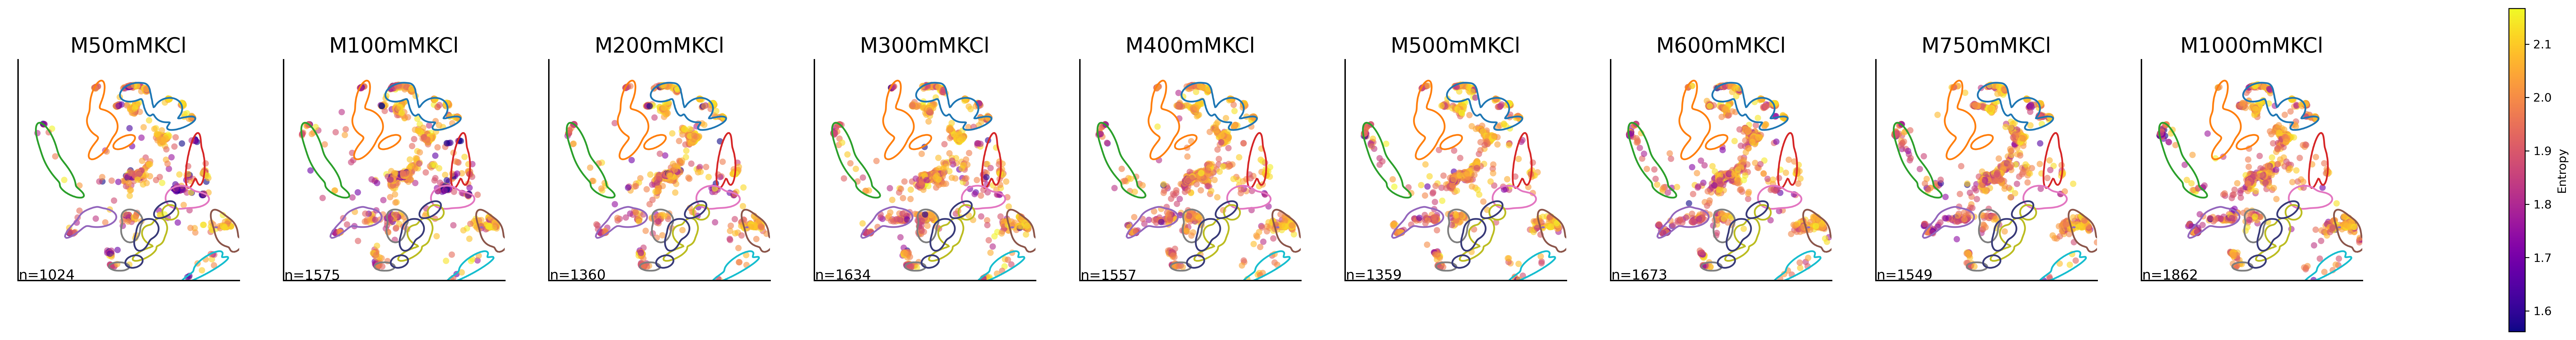

In [21]:
reducer = joblib.load('../../saved_models/UMAP/atlas_pp.joblib')
saved_atlas_density_models = joblib.load('../../saved_models/UMAP/atlas_pp_density_models.joblib')

cutoff = np.quantile(perplexity_spot, 1.0)
counter = 0

z_h = reducer.transform(embedding_spot)
ax_min = np.min(z_h)
ax_max = np.max(z_h)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(ncols=len(ordered_label_spot), nrows=1, figsize=(5 * len(ordered_label_spot), 5));
for l in ordered_label_spot:
    idx = (new_label_spot == l) & (perplexity_spot <= cutoff)
    z = z_h[idx, ...]
    with plt.style.context(spstyle.get_style('nature-reviews')):
        ax = axes[counter]
        counter += 1
        s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=30, alpha=0.6, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        ax.set_xlim([ax_min, ax_max])
        ax.set_ylim([ax_min, ax_max])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(f'{l}')
        ax.text(x=ax.get_xlim()[0]+ 0.1, y=ax.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 12})
    contour_counter = 0
    for l in saved_atlas_density_models:
        color = plt.cm.tab20.colors + plt.cm.tab20b.colors[::2]
        x = np.linspace(np.min(z_h[:, 0]) - 1, np.max(z_h[:, 0]) + 1, num=200)
        y = np.linspace(np.min(z_h[:, 1]) - 1, np.max(z_h[:, 1]) + 1, num=200)
        X, Y = np.meshgrid(x, y)
        clf = saved_atlas_density_models[l]
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = clf.score_samples(XX)
        Z = np.exp(Z.reshape(X.shape))
        cmap = plt_colors.LinearSegmentedColormap.from_list("", [color[contour_counter], color[contour_counter], color[contour_counter]])
        if 'n' not in l:
            CS = ax.contour(
                X, Y, Z, cmap=cmap, levels=[1e-2]
            )
        contour_counter += 1
color_bar = fig.colorbar(s, ax=axes, label="Entropy")
color_bar.set_alpha(1)
color_bar.draw_all()
if cutoff >= np.quantile(perplexity_spot, 0.9):
    plt.savefig('figures/rna_bubble_perplexity_umap_atlas.svg')
else:
    plt.savefig('figures/rna_bubble_perplexity_umap_atlas_threshold.svg')
plt.show()

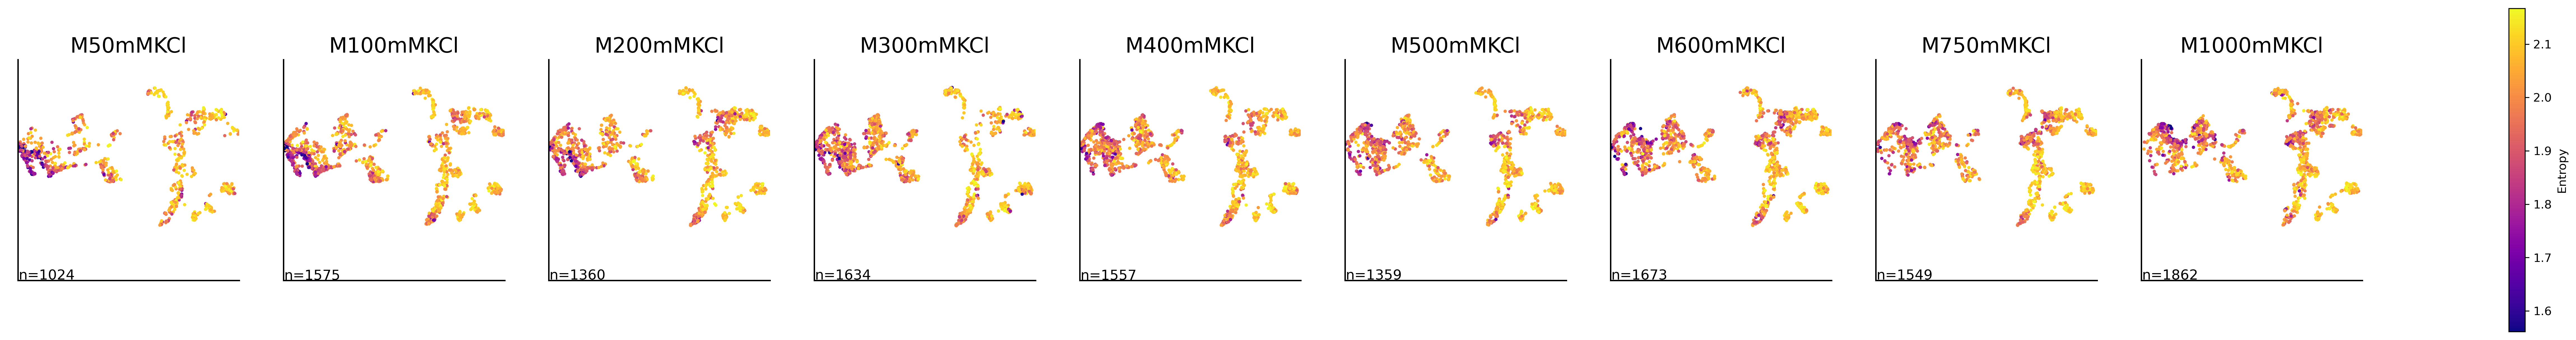

In [22]:
reducer = umap.UMAP(n_epochs=500, n_neighbors=30, min_dist=0.0, random_state=np.random.RandomState(60), n_components=2, negative_sample_rate=15)
reducer.fit_transform(embedding_spot)

counter = 0

z_h = reducer.transform(embedding_spot)
ax_min = np.min(z_h)
ax_max = np.max(z_h)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(ncols=len(ordered_label_spot), nrows=1, figsize=(5 * len(ordered_label_spot), 5));
for l in ordered_label_spot:
    idx = (new_label_spot == l) & (perplexity_spot <= cutoff)
    z = z_h[idx, ...]
    with plt.style.context(spstyle.get_style('nature-reviews')):
        ax = axes[counter]
        counter += 1
        if cutoff >= np.quantile(perplexity_spot, 0.9):
            s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=8, alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        else:
            s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=30, alpha=0.5, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        ax.set_xlim([ax_min, ax_max])
        ax.set_ylim([ax_min, ax_max])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(f'{l}')
        ax.text(x=ax.get_xlim()[0]+ 0.1, y=ax.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 12})
color_bar = fig.colorbar(s, ax=axes, label="Entropy")
color_bar.set_alpha(1)
color_bar.draw_all()
if cutoff >= np.quantile(perplexity_spot, 0.9):
    plt.savefig('figures/rna_bubble_perplexity_umap_contour.svg')
else:
    plt.savefig('figures/rna_bubble_perplexity_umap_threshold.svg')

plt.show()